In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
DO_ALL = True # 전체 실행하면서 시간 걸리는 걸 Pass 하려면 이걸 False ...

In [2]:
if DO_ALL:
    !pip install sentence-transformers==0.3.0
    !pip install transformers==3.0.2
    !pip install wikipedia
    !pip install konlpy

     |████████████████████████████████| 61 kB 380 kB/s eta 0:00:011
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.0-py3-none-any.whl size=86752 sha256=c54c5b0d43fc9ae721c58d7d1a8768e7c258a37f6abf88f39377c58d2bbc0f04
  Stored in directory: /root/.cache/pip/wheels/3e/15/94/49bc84289d2c77b5059bca513f840c6006d4e2cc7f10275d49
Successfully built sentence-transformers
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 769 kB 4.4 MB/s eta 0:00:01


     |████████████████████████████████| 3.0 MB 50.1 MB/s eta 0:00:01     |████████████████████████████████| 3.0 MB 50.1 MB/s 
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.9.3
    Uninstalling tokenizers-0.9.3:
      Successfully uninstalled tokenizers-0.9.3
  Attempting uninstall: transformers
    Found existing installation: transformers 3.5.1
    Uninstalling transformers-3.5.1:
      Successfully uninstalled transformers-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.2.2 requires transformers<3.6,>=3.4, but you have transformers 3.0.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11685 sha256=662445331c5ef0b70ffd6a54fa0f3f9fc7238b6df5bee9093549bce8a5

In [3]:
# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from tensorflow.python.framework import tensor_shape
import keras.utils as ku 

# set seeds for reproducability
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(2)
seed(1)

import pandas as pd
import numpy as np
import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
org_text = """
옛날 어느 집에 귀여운 여자 아기가 태어났어요.
아기는 무럭무럭 자라서, 예쁘고 마음씨 고운 소녀가 되었어요.
그러던 어느날, 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요.
소녀의 아버지는 홀로 남은 소녀가 걱정되었어요.
그래서 얼마 후 새어머니를 맞이했어요.
새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요.
그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요.
새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요.
그런데 이번에는 아버지마저 돌아가셨어요.
소녀는 하녀처럼 하루 종일 쓸고, 닦고, 집안일을 도맡아 했어요.
해도 해도 끝이 없는 집안일이 힘들어 지칠때면
난롯가에 앉아서 잠시 쉬곤 했지요.
"엄마, 저애를 신데렐라라고 불러야겠어요."
"온통 재투성이잖아요. 호호호!" 두 언니는 소녀를 놀려 댔어요.
어느 날, 왕궁에서 무도회가 열렸어요.
신데렐라의 집에도 초대장이 왔어요.
새어머니는 언니들을 데리고 무도회장으로 떠났어요.
신데렐라도 무도회에 가고 싶었어요.
혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요.
"신데렐라, 너도 무도회에 가고 싶니?"
신데렐라가 고개를 들어보니, 마법사 할머니가 빙그레 웃고 있었어요.
"내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리, 도마뱀을 구해 오렴."
마법사 할머니가 주문을 외웠어요.
그리고 지팡이로 호박을 건드리자, 호박이 화려한 황금 마차로 변했어요.
이번에는 생쥐와 도마뱀을 건드렸어요.
그랬더니 생쥐는 흰말로, 도마뱀은 멋진 마부로 변했답니다.
신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요.
"신데렐라, 발을 내밀어 보거라."
할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요.
"신데렐라, 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로, 흰말은 생쥐로, 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지?"
왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요.
왕자님은 무도회장에 모인 다른 아가씨들은 쳐다보지도 않고,
신데렐라하고만 춤을 추었어요.
신데렐라는 왕자님과 춤을 추느라 시간 가는 줄도 몰랐어요.
땡, 땡, 땡...... 벽시계가 열두 시를 알리는 소리에 신데렐라는 화들짝 놀랐어요.
신데렐라가 허둥지둥 왕궁을 빠져나가는데,
유리 구두 한 짝이 벗겨졌어요.
하지만 구두를 주울 틈이 없었어요.
신데렐라를 뛰쫓아오던 왕자님은 층계에서 유리 구두 한 짝을 주웠어요.
왕자님은 유리 구두를 가지고 임금님께 가서 말했어요.
"이 유리 구두의 주인과 결혼하겠어요."
그래서 신하들은 유리 구두의 주인을 찾아 온 나라를 돌아다녔어요.
언니들은 발을 오므려도 보고, 구두를 늘려도 보았지만 한눈에 보기에도 유리 구두는 너무 작았어요.
그때, 신데렐라가 조용히 다가와 말했어요.
"저도 한번 신어 볼 수 있나요?"
신데렐라는 신하게 건넨 유리 구두를 신었어요,
유리 구두는 신데렐라의 발에 꼭 맞았어요.
신하들은 신데렐라를 왕궁으로 데리고 갔어요.
그 뒤 신데렐라는 왕자님과 결혼하여 오래오래 행복하게 살았대요.
"""

In [5]:
# 간단한 전처리
def clean_text(txt):
    txt = txt.replace('\n',' ')
    txt = txt.replace('=','')
    txt = txt.replace('\"','')   
    txt = txt.replace('\'','')
    txt = txt.replace(',','')
    txt = txt.replace('..','')
    txt = txt.replace('.','. ')
    txt = txt.replace('  ',' ')
    return txt 

org_text = clean_text(org_text).strip()
org_text

'옛날 어느 집에 귀여운 여자 아기가 태어났어요. 아기는 무럭무럭 자라서 예쁘고 마음씨 고운 소녀가 되었어요. 그러던 어느날 소녀의 어머니가 병이들어 그만 세상을 떠나고 말았어요. 소녀의 아버지는 홀로 남은 소녀가 걱정되었어요. 그래서 얼마 후 새어머니를 맞이했어요. 새어머니는 소녀보다 나이가 위인 두 딸을 데리고 왔어요. 그러나 새어머니와 언니들은 성질이 고약한 심술쟁이들이었어요. 새어머니는 소녀가 자기 딸들보다 예쁘고 착한 게 못마땅했어요. 그런데 이번에는 아버지마저 돌아가셨어요. 소녀는 하녀처럼 하루 종일 쓸고 닦고 집안일을 도맡아 했어요. 해도 해도 끝이 없는 집안일이 힘들어 지칠때면 난롯가에 앉아서 잠시 쉬곤 했지요. 엄마 저애를 신데렐라라고 불러야겠어요. 온통 재투성이잖아요. 호호호! 두 언니는 소녀를 놀려 댔어요. 어느 날 왕궁에서 무도회가 열렸어요. 신데렐라의 집에도 초대장이 왔어요. 새어머니는 언니들을 데리고 무도회장으로 떠났어요. 신데렐라도 무도회에 가고 싶었어요. 혼자 남은 신데렐라는 훌쩍훌쩍 울기 시작했어요. 신데렐라 너도 무도회에 가고 싶니? 신데렐라가 고개를 들어보니 마법사 할머니가 빙그레 웃고 있었어요. 내가 너를 무도회에 보내주마 호박 한개와 생쥐 두마리 도마뱀을 구해 오렴. 마법사 할머니가 주문을 외웠어요. 그리고 지팡이로 호박을 건드리자 호박이 화려한 황금 마차로 변했어요. 이번에는 생쥐와 도마뱀을 건드렸어요. 그랬더니 생쥐는 흰말로 도마뱀은 멋진 마부로 변했답니다. 신데렐라의 옷도 구슬 장식이 반짝이는 예쁜 드레스로 바뀌웠어요. 신데렐라 발을 내밀어 보거라. 할머니는 신데렐라에게 반짝반짝 빛나는 유리 구두를 신겨 주었어요. 신데렐라 밤 열두시가 되면 모든게 처음대로 돌아간단다. 황금 마차는 호박으로 흰말은 생쥐로 마부는 도마뱀으로 변하게 돼. 그러니까 반드시 밤 열두 시가 되기 전에 돌아와야 해. 알겠지? 왕자님도 아름다운 신데렐라에게 마음을 빼았겼어요. 왕자님은 무도회장에 모인 다른 아가씨들은 쳐다보지도 않고 신데렐라하고만 

In [6]:
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer

if DO_ALL:
    # embedder download...
    embedder = SentenceTransformer('xlm-r-large-en-ko-nli-ststb')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
100%|██████████| 1.80G/1.80G [03:11<00:00, 9.39MB/s] 


In [7]:

# 생성된 문장의 원문 유사도를 측정하기 위한 함수

import scipy
#print(doc_emb)
def similarity_discriminator(queries,org_embedding):
    # queries : 복수의 문장의 2차원 배열 (None,1)
    # org_embedding : 비교 대상의 원문 embedding 1차원 배열 (1,)
    # return : 결과 score 배열 (None,)
    total_score = 0
    query_embeddings = embedder.encode(queries,show_progress_bar=False)
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], [org_embedding], "cosine")[0]
        results = zip(range(len(distances)), distances)
        for idx, distance in results:
            total_score += 1-distance
    return total_score

In [8]:
# 원문의 embedding...
org_text_emb = embedder.encode([org_text],show_progress_bar=False)[0]

In [9]:
org_text_emb

array([ 0.15200944,  0.9212076 , -0.17669234, ..., -0.72806716,
        0.742245  , -0.41552886], dtype=float32)

In [10]:
org_term_set = (' ' + org_text + ' ').split(' ')

_MAX_GEN_TOKEN = 40
_NOISE_DIM = len(org_term_set)

word_table = {}

for index, word in zip(range(len(org_term_set)),org_term_set):
    word_table[index] = word
    
print('Token table of origin text')
print('---------------------------------------------')
print(' Code         Token      ')
print('')
for k in word_table.keys():
  print( f'  {str(k).ljust(8)}    {word_table[k]}')
print('---------------------------------------------')

Token table of origin text
---------------------------------------------
 Code         Token      

  0           
  1           옛날
  2           어느
  3           집에
  4           귀여운
  5           여자
  6           아기가
  7           태어났어요.
  8           아기는
  9           무럭무럭
  10          자라서
  11          예쁘고
  12          마음씨
  13          고운
  14          소녀가
  15          되었어요.
  16          그러던
  17          어느날
  18          소녀의
  19          어머니가
  20          병이들어
  21          그만
  22          세상을
  23          떠나고
  24          말았어요.
  25          소녀의
  26          아버지는
  27          홀로
  28          남은
  29          소녀가
  30          걱정되었어요.
  31          그래서
  32          얼마
  33          후
  34          새어머니를
  35          맞이했어요.
  36          새어머니는
  37          소녀보다
  38          나이가
  39          위인
  40          두
  41          딸을
  42          데리고
  43          왔어요.
  44          그러나
  45          새어머니와
  46          언니들은
  47          성질이
  48          고약한
  49     

In [14]:
# Print iterations progress
class ProgressBar:

    def __init__(self,total=20, prefix = '', suffix = '', decimals = 1, length = 20, fill = '█', printEnd = "\r"):
        self.total = total
        self.prefix = prefix
        self.suffix = suffix
        self.decimals = decimals
        self.length = length
        self.fill = fill
        self.printEnd = printEnd
        self.ite = 0

    def printProgress(self,iteration, text):
        self.ite += iteration
        percent = ("{0:." + str(self.decimals) + "f}").format(100 * (self.ite / float(self.total)))

        filledLength = int(self.length * self.ite // self.total)
        bar = self.fill * filledLength + '-' * (self.length - filledLength)
        print(f'\r{self.prefix} |{bar}| {percent}% {self.suffix}  {text}', end="", flush=True)
        # Print New Line on Complete
        if self.ite == self.total: 
            print()

In [77]:
term_weight = np.zeros(_NOISE_DIM,)

filters=np.array([[0,1],[0,1,2],[0,1,2,3],[0,1,2,3,4]])#,[0,2],[0,2,4],[0,2,4,6],[0,2,4,6,8]])
#filters=np.array([[0,2],[0,2,4],[0,2,4,6],[0,2,4,6,8]])

terms = np.array(list(word_table.values()))

pb = ProgressBar(len(filters),prefix='Analysis...')
for filter in filters:
    #print(filter)
    last_idx = len(terms)-(max(filter)+1)
    for conv in range(last_idx):
        pb.printProgress(0,f'filer:{filter} {conv}/{last_idx}       ')
        t = np.array(filter) + conv
        part_sen = ' '.join(terms[t])
        part_sen = part_sen.replace('신데렐라','')
        part_sen = part_sen.replace('소녀','')        
        score = similarity_discriminator([part_sen],org_text_emb)
        term_weight[t] += score
    pb.printProgress(+1,f'filer:{filter}')

Analysis... |████████████████████| 100.0%   filer:[0, 1, 2, 3, 4]335/336       


peaks count: 49


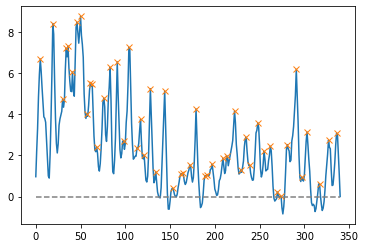

In [83]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks

peaks, _ = find_peaks(term_weight, height=0)
print('peaks count:',len(peaks))
plt.plot(term_weight)
plt.plot(peaks, term_weight[peaks], "x")
plt.plot(np.zeros_like(term_weight), "--", color="gray")
plt.show()

peaks count: 32


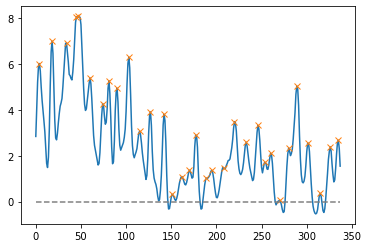

In [86]:
N = 4
w = np.ones(N) / N

data_ma = np.convolve(term_weight, w, mode='valid')

peaks, _ = find_peaks(data_ma, height=0)
print('peaks count:',len(peaks))
plt.plot(data_ma)
plt.plot(peaks, data_ma[peaks], "x")
plt.plot(np.zeros_like(data_ma), "--", color="gray")
plt.show()


In [87]:
text = ""
for k in peaks:
    print(k,term_weight[k],word_table[k])
    text += word_table[k]+' '  

text

4 5.940020173409681 귀여운
18 5.944224115148148 소녀의
34 7.229419484450927 새어머니를
45 8.244841817144138 새어머니와
47 7.971569952326227 성질이
60 5.171507222741531 아버지마저
74 3.324347862747871 없는
81 4.700074855472882 쉬곤
90 4.72547083182386 두
103 5.4276146816313044 왔어요.
115 2.5860102336808932 신데렐라는
127 3.739768484798249 마법사
142 2.6417968990650076 오렴.
151 0.22997262241094896 호박이
162 1.1081605803582741 흰말로
170 1.1562678863795388 장식이
177 1.6511573280365153 내밀어
189 1.0050296666434537 열두시가
195 1.314495956539448 마차는
208 1.4849871197652882 되기
220 2.730765930230277 모인
233 2.4311523405943927 가는
246 3.0970568412157577 놀랐어요.
254 1.5818130498563092 짝이
260 1.7442140053368644 없었어요.
270 0.21814666576517527 왕자님은
280 2.2875588352840643 주인과
289 4.155713020131083 나라를
301 1.8194906092571013 구두는
315 0.15651613780816354 신데렐라는
326 2.0639785586995463 맞았어요.
335 2.4995555746922347 왕자님과


'귀여운 소녀의 새어머니를 새어머니와 성질이 아버지마저 없는 쉬곤 두 왔어요. 신데렐라는 마법사 오렴. 호박이 흰말로 장식이 내밀어 열두시가 마차는 되기 모인 가는 놀랐어요. 짝이 없었어요. 왕자님은 주인과 나라를 구두는 신데렐라는 맞았어요. 왕자님과 '

In [93]:
similarity_discriminator([text],org_text_emb)

0.6371708122399575

In [94]:
sota_text = """
소녀의 언니들은 심술쟁이들 이었어요. 소녀는 집안일을 도맡아 했어요. 신데렐라도 무도회에 가고 싶었어요.
마법사 할머니가 도마뱀을 구해 주문을 외웠어요. 황금 마차로 드레스로 바뀌웠어요. 밤 열두시가 되면 처음대로 돌아간단다. 왕자님도 신데렐라에게 마음을 빼았겼어요. 
벽시계가 열두 시를 알리는 소리에 놀랐어요. 유리 구두 벗겨졌어요. 왕자님은 주인을 찾아 돌아다녔어요. 구두는 신데렐라의 발에 맞았어요.
"""

In [92]:
similarity_discriminator([sota_text],org_text_emb)

0.5097759687847567